In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 14.4 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 6.6 MB 52.0 MB/s 
     |████████████████████████████████| 596 kB 68.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 15.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


In [3]:
! pip install pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torchcrf import CRF
from transformers import BertTokenizer, BertTokenizerFast, BertForSequenceClassification, get_linear_schedule_with_warmup
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import TokenClassifierOutput
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from transformers.trainer_utils import IntervalStrategy
import seaborn as sns

In [5]:
PRE_TRAINED_MODEL_NAME = "bert-base-multilingual-uncased"

In [6]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [7]:
tokens_data = pd.read_csv('train_tokens.csv', dtype={'sent_index': str, 'token': str, 'tag': str}, sep=';')
tokens_data_test = pd.read_csv('test_tokens.csv', dtype={'sent_index': str, 'token': str, 'tag': str}, sep=';')
tokens_data_eval = pd.read_csv('eval_tokens.csv', dtype={'sent_index': str, 'token': str, 'tag': str}, sep=';')

In [8]:
sents_data = pd.read_csv('train_sents.csv', dtype={'sent_index': str, 'sent_text': str, 'def': str}, sep=';').rename(columns={"def": "has_def"})
sents_data_test = pd.read_csv('test_sents.csv', dtype={'sent_index': str, 'sent_text': str, 'def': str}, sep=';').rename(columns={"def": "has_def"})
sents_data_eval = pd.read_csv('eval_sents.csv', dtype={'sent_index': str, 'sent_text': str, 'has_def': str}, sep=';')

Посчитаем среднюю длину преложения в токенах.

In [9]:
sent_lens = []
for ind in set(list(tokens_data['sent_index'])):
    sent_len = len(tokens_data.loc[tokens_data.sent_index == ind])
    sent_lens.append(sent_len)
sum(sent_lens)/len(sent_lens)

28.344135802469136

In [10]:
sent_lens = []
for ind in set(list(tokens_data_test['sent_index'])):
    sent_len = len(tokens_data_test.loc[tokens_data_test.sent_index == ind])
    sent_lens.append(sent_len)
sum(sent_lens)/len(sent_lens)

28.295698924731184

In [11]:
tokens_data_test.head()

,sent_index,token,tag
0,12,Как,O
1,12,дисциплина,O
2,12,",",O
3,12,имеющая,O
4,12,ряд,O


In [12]:
def bert_style_tokenize(df, df_sents):
    tokens = []
    tags = []
    masks = []
    for ind in set(list(df['sent_index'])):
        if list(df_sents.loc[df_sents.sent_index == ind]['has_def']) == [1]:
            tokens_sent = []
            tags_sent = []
            masks_sent = []
            tokens_list = list(df.loc[df.sent_index == ind]['token'])
            tags_list = list(df.loc[df.sent_index == ind]['tag'])
            for i, t in enumerate(tokens_list):
                bert_t = tokenizer.tokenize(t)
                mask = []
                tag_t = []
                tag_t.append(tags_list[i])
                mask.append(1)
                tag_t.extend(['X' for i in range(len(bert_t)-1)])
                mask.extend([0 for i in range(len(bert_t)-1)])
                tokens_sent.extend(bert_t)
                masks_sent.extend(mask)
                tags_sent.extend(tag_t)
            tokens.append(tokens_sent)
            tags.append(tags_sent)
            masks.append(masks_sent)
    return tokens, tags, masks

bert_tokens_train, bert_tags_train, masks_train = bert_style_tokenize(tokens_data, sents_data)
bert_tokens_test, bert_tags_test, masks_test = bert_style_tokenize(tokens_data_test, sents_data_test)
bert_tokens_eval, bert_tags_eval, masks_eval = bert_style_tokenize(tokens_data_eval, sents_data_eval)

In [13]:
sents_data[20:30]

,sent_index,sent_text,has_def
20,1378,Парадигма личного спряжения в европейских язык...,0
21,11336,"Си́нтез (др.-греч. σύνθεσις «соединение, склад...",1
22,14550,"Онтолингвистика — раздел лингвистики, изучающи...",1
23,18847,"Бэкон, Фрэнсис — английский философ, историк и...",1
24,8714,"Избыточность языка — статистическая величина, ...",1
25,3974,"Коллокация — словосочетание, имеющее признаки ...",1
26,51,Лексикология изучает индивидуальные свойства о...,0
27,11457,В социолингвистике термином престиж обозначают...,1
28,1998,"Склоне́ние (от лат. declinatio, «отклонение» о...",1
29,4838,"Вре́мя — грамматическая категория глагола, выр...",1


In [14]:
print(bert_tokens_train[0])
print(bert_tags_train[0])
print(masks_train[0])

['об', '##об', '##ща', '##ющее', 'слово', '[UNK]', 'это', 'слово', 'при', 'одно', '##ро', '##дных', 'члена', '##х', 'пред', '##ложения', ',', 'на', '##зы', '##ва', '##ющее', 'родов', '##ое', 'понятие', '(', 'общее', ')', ',', 'по', 'отношению', 'к', 'которому', 'одно', '##ро', '##дные', 'члены', 'пред', '##ложения', 'являются', 'видов', '##ыми', 'по', '##нятия', '##ми', '(', 'част', '##ными', ')', ';', 'или', 'на', '##зы', '##ва', '##ющее', 'цел', '##ое', ',', 'по', 'отношению', 'к', 'которому', 'одно', '##ро', '##дные', 'члены', 'об', '##оз', '##на', '##чают', 'части', '.']
['B-TERM', 'X', 'X', 'X', 'I-TERM', 'O', 'O', 'B-DEF', 'I-DEF', 'I-DEF', 'X', 'X', 'I-DEF', 'X', 'I-DEF', 'X', 'I-DEF', 'I-DEF', 'X', 'X', 'X', 'I-DEF', 'X', 'I-DEF', 'I-DEF', 'I-DEF', 'I-DEF', 'I-DEF', 'I-DEF', 'I-DEF', 'I-DEF', 'I-DEF', 'I-DEF', 'X', 'X', 'I-DEF', 'I-DEF', 'X', 'I-DEF', 'I-DEF', 'X', 'I-DEF', 'X', 'X', 'I-DEF', 'I-DEF', 'X', 'I-DEF', 'I-DEF', 'I-DEF', 'I-DEF', 'X', 'X', 'X', 'I-DEF', 'X', 'I-DEF'

In [15]:
len(bert_tags_train)

338

In [16]:
MAX_LEN = 80

In [17]:
tags_2id = {'B-TERM':0, 'I-TERM':1, 'B-DEF':2, 'I-DEF':3, 'O':4, 'X':5}

In [18]:
class TokensDataset(torch.utils.data.Dataset):

    def __init__(self, bert_tokens, bert_tags, masks, tokenizer, MAX_LEN):
        self.bert_tokens = bert_tokens
        self.bert_tags = bert_tags
        self.masks = masks
        self.tokenizer = tokenizer
        self.MAX_LEN = MAX_LEN
  
    def __getitem__(self, idx):
        tokens = self.bert_tokens[idx][:]
        tags = self.bert_tags[idx][:]
        masks_id = self.masks[idx][:]
        tags = ['X'] + tags + ['X']
        masks_id = [0]+masks_id+[0]
        tags = [tags_2id[i] for i in tags]
        tokens.append('SEP')
        tokens = ['CLS'] + tokens
        tokens2ids = tokenizer.convert_tokens_to_ids(tokens)
        tokens_mask = [1 for i in range(len(tokens2ids))]
        if len(tokens)>self.MAX_LEN:
            tokens2ids = tokens2ids[:self.MAX_LEN]
            tags = tags[:self.MAX_LEN]
            masks_id = masks_id[:self.MAX_LEN]
            tokens_mask = tokens_mask[:self.MAX_LEN]
        else:
            tokens2ids.extend([0 for i in range(MAX_LEN-len(tokens2ids))])
            tags.extend([tags_2id['X'] for i in range(MAX_LEN-len(tags))])
            masks_id.extend([0 for i in range(MAX_LEN-len(masks_id))])
            tokens_mask.extend([0 for i in range(MAX_LEN-len(tokens_mask))])
        return {
            'ids': torch.tensor(tokens2ids, dtype=torch.long),
            'targets': torch.tensor(tags, dtype=torch.long),
            'crf_masks': torch.tensor(masks_id).bool(),
            'bert_masks': torch.tensor(tokens_mask).bool()
        }

    def __len__(self):
        return len(self.bert_tokens)

In [19]:
train_dataset = TokensDataset(bert_tokens_train, bert_tags_train, masks_train, tokenizer, MAX_LEN)
test_dataset = TokensDataset(bert_tokens_test, bert_tags_test, masks_test, tokenizer, MAX_LEN)
eval_dataset = TokensDataset(bert_tokens_eval, bert_tags_eval, masks_eval, tokenizer, MAX_LEN)

In [20]:
train_data_loader = DataLoader(train_dataset, 16)
test_data_loader = DataLoader(test_dataset, 16)
eval_data_loader = DataLoader(test_dataset, 16)

In [21]:
next(iter(train_data_loader))

{'bert_masks': tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]]),
 'crf_masks': tensor([[False,  True, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         ...,
         [False,  True, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False]]),
 'ids': tensor([[  100, 12479, 38938,  ...,     0,     0,     0],
         [  100, 60400, 39794,  ...,     0,     0,     0],
         [  100,   323, 68277,  ...,     0,     0,     0],
         ...,
         [  100,   336, 18789,  ...

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Загружаем трансформер, обученный на бинарную классификацию

In [24]:
state_dict = torch.load('/content/drive/MyDrive/bms_multiling_uncased_10.bin', map_location=torch.device('cpu'))

In [25]:
encoder = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, state_dict=state_dict)

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['bert.bert.encoder.layer.8.attention.output.dense.weight', 'bert.bert.encoder.layer.4.attention.output.dense.weight', 'bert.bert.pooler.dense.bias', 'bert.bert.encoder.layer.2.attention.self.query.bias', 'bert.bert.encoder.layer.6.intermediate.dense.weight', 'bert.bert.encoder.layer.3.output.LayerNorm.bias', 'bert.bert.encoder.layer.9.attention.self.key.bias', 'bert.bert.encoder.layer.0.attention.self.query.weight', 'bert.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.bert.encoder.layer.10.intermediate.dense.bias', 'bert.bert.encoder.layer.0.attention.self.key.weight', 'bert.bert.encoder.layer.7.attention.self.query.weight', 'bert.bert.encoder.layer.8.output.LayerNorm.weight', 'bert.bert.encoder.layer.1.attention.output.dense.bias', 'bert.bert.encoder.layer.4.attention.self.value.weight', 'bert.bert.encoder.layer.8.attention.self.query.bias', 'bert.bert.enc

Замораживаем веса энкодера, чтобы они не обучались больше

In [26]:
for param in encoder.parameters():
    param.requires_grad = False

In [27]:
class BertCRF(nn.Module):

    def __init__(self, bert_model, num_labels, hidden_dropout_prob, hidden_size):
        super().__init__()
        self.num_labels = num_labels

        self.bert = bert_model
        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.crf = CRF(num_tags=num_labels, batch_first=True)

    def forward(
        self,
        input_ids=None,
        attention_mask=None):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask)

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        return logits

    def loss(self, logits, labels, crf_masks):
        logits = logits[:,1:]
        labels = labels[:,1:]
        crf_masks = crf_masks[:,1:]
        log_likelihood = self.crf(logits, labels, mask=crf_masks)
        loss = 0 - log_likelihood
        return loss
    
    def predict(self, logits, crf_masks):
        logits = logits[:,1:]
        crf_masks = crf_masks[:,1:]
        tags = self.crf.decode(logits, mask=crf_masks)
        return tags

In [28]:
def get_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    real_values = []

    for d in data_loader:
        input_ids = d['ids'].to(device)
        targets = d['targets'].to(device)
        crf_masks = d['crf_masks'].to(device)
        bert_masks = d['bert_masks'].to(device)

        output = bertCrf(input_ids=input_ids,
                        attention_mask=bert_masks)
        pred = bertCrf.predict(output, crf_masks)
        targets_list = []
        for sent_tar in targets:
            targets_sent = [i for i in sent_tar.tolist() if i != 5]
            targets_list.extend(targets_sent)
        pred = sum(pred, [])
        targets = targets_list
        try:
            assert len(pred)==len(targets)
        except AssertionError:
            print(len(pred), len(targets))
            print(crf_masks)
            raise
        predictions.extend(pred)
        real_values.extend(targets)
    # print(len(predictions)) 
    # print(len(real_values))
    return predictions, real_values
    predictions_stack = []
    real_values_stack = []
    for sent in predictions:
        for i in sent:
            predictions_stack.append(i)
    for sent in real_values:
        for i in sent:
            real_values_stack.append(i)
    return predictions_stack, real_values_stack

In [29]:
def train_epoch(model, data_loader, optimizer):
    model.train()
    loss_epoch=0
    for d in data_loader:
        input_ids = d['ids'].to(device)
        targets = d['targets'].to(device)
        crf_masks = d['crf_masks'].to(device)
        bert_masks = d['bert_masks'].to(device)
        output = model(input_ids=input_ids,
                attention_mask=bert_masks)
        
        loss = model.loss(logits=output, labels=targets, crf_masks=crf_masks)
        loss.backward()
        loss_epoch += loss.item()
        optimizer.step()
        optimizer.zero_grad()
    return loss_epoch


In [30]:
def evaluate(data_loader):
    bertCrf.eval()
    loss_epoch = 0
    preds = []
    for d in data_loader:
        input_ids = d['ids'].to(device)
        targets = d['targets'].to(device)
        crf_masks = d['crf_masks'].to(device)
        bert_masks = d['bert_masks'].to(device)
        output = bertCrf(input_ids=input_ids,
                attention_mask=bert_masks)
        pred = bertCrf.predict(output, crf_masks)
        preds.append(pred)
        loss = bertCrf.loss(logits=output, labels=targets, crf_masks=crf_masks)
        loss_epoch += loss.item()
    return preds, loss_epoch

In [31]:
losses_train = []
losses_eval = []
n_epochs = 50
bertCrf = BertCRF(encoder, 6, 0.2, 768)
bertCrf.to(device)
optimizer = optim.Adam(bertCrf.parameters(), lr=0.0002)
for e in range(n_epochs):
    print(f"Epoch: {e}")
    train_loss_epoch = train_epoch(bertCrf, train_data_loader, optimizer)
    losses_train.append(train_loss_epoch)
    preds, eval_loss_epoch = evaluate(test_data_loader)
    losses_eval.append(eval_loss_epoch)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49


In [32]:
import matplotlib.pyplot as plt
def plot_losses(losses, val_losses):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.title('Loss value')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

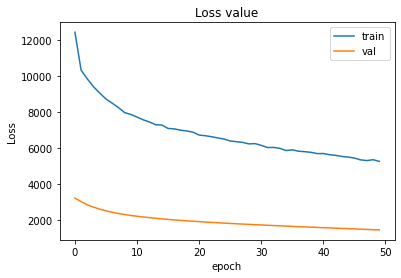

In [33]:
plot_losses(losses_train, losses_eval)

In [34]:
y_pred, y_test = get_predictions(bertCrf, eval_data_loader)

In [35]:
print(classification_report(y_test, y_pred, target_names=['0', '1', '2', '3', '4'], digits=3))

              precision    recall  f1-score   support

           0      0.326     0.806     0.464       124
           1      0.097     0.129     0.111        93
           2      0.000     0.000     0.000       115
           3      0.803     0.793     0.798      1801
           4      0.561     0.513     0.536       913

    accuracy                          0.659      3046
   macro avg      0.357     0.448     0.382      3046
weighted avg      0.659     0.659     0.655      3046



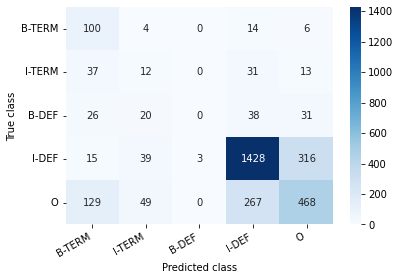

In [36]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['B-TERM', 'I-TERM', 'B-DEF', 'I-DEF', 'O'], columns=['B-TERM', 'I-TERM', 'B-DEF', 'I-DEF', 'O'])
show_confusion_matrix(df_cm)